In [1]:
import numpy as np
from xgboost import XGBRanker
from sklearn.metrics import ndcg_score
import matplotlib.pyplot as plt
import psycopg2
from gensim.models.doc2vec import Doc2Vec
from gensim.utils import simple_preprocess
import tensorflow as tf
import tensorflow.keras.backend as K
from faiss import read_index
from psycopg2.extras import execute_values
import pickle
import pandas as pd
from operator import itemgetter

2023-09-25 08:09:41.301564: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load fair rank

In [6]:
connection = psycopg2.connect(
    user="postgres",
    password="postgres",
    host="127.0.0.1",
    port="54320",
    database="stack_overflow",
)

In [2]:
after_fair_df = pd.read_csv("after_fair_data.csv")
after_fair_df.head()

,q_id,u_id,developed_country,idx,pscore
0,70547027,100297,1,0,2.340971
1,70547027,7574575,0,1,2.266549
2,70547027,11923558,0,2,2.071728
3,70547027,1624921,1,3,2.033441
4,70547027,325565,1,4,1.930067


In [8]:
with connection:
    with connection.cursor() as cursor:
        execute_values(
            cursor,
            """select q_id, u_id, q_a.score
                                FROM (VALUES %s) AS base_questions (q_id, u_id)
                                JOIN posts_19 q_a ON q_a.parent_id = q_id
                                WHERE q_a.owner_user_id=u_id""",
            after_fair_df[["q_id", "u_id"]].values.tolist(),
            page_size=len(after_fair_df),
        )
        answers_dataset = pd.DataFrame(
            cursor.fetchall(), columns=["q_id", "u_id", "score"]
        )

In [14]:
full_dataset = after_fair_df.merge(answers_dataset, on=["q_id", "u_id"], how="left")
full_dataset["is_answer"] = (~full_dataset["score"].isna()).astype(int)
full_dataset = full_dataset.sort_values(by=["q_id", "pscore"], ascending=False)
full_dataset.head()

,q_id,u_id,developed_country,idx,pscore,score,is_answer
397200,74681417,100297,1,0,2.263848,NaN,0
397201,74681417,3874623,1,1,2.024328,NaN,0
397202,74681417,5923139,1,2,1.902712,NaN,0
397203,74681417,7574575,0,3,1.897878,NaN,0
397204,74681417,325565,1,4,1.845899,NaN,0


In [35]:
full_dataset["is_answer"].sum()

444

# Evaluate recall

In [22]:
posts_ids = full_dataset["q_id"].unique().tolist()
len(posts_ids)

3973

In [36]:
top_k = range(0, 100, 5)
mean_retrieved_documents = []
for k in top_k:
    mean_retrieved_documents.append(
        full_dataset.groupby("q_id")
        .apply(lambda x: x.head(k)["is_answer"].sum())
        .median()
    )

In [30]:
mean_retrieved_documents

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [23]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute(
            """select q_a.parent_id, count(*) as answers
                            FROM posts_19 q_a
                            where q_a.parent_id in %s
                            group by q_a.parent_id""",
            (tuple(posts_ids),),
        )
        q_answers = cursor.fetchall()

In [24]:
q_answers = {q_id: answers for q_id, answers in q_answers}

In [90]:
len()

429

In [92]:
len(after_fair_df[after_fair_df["developed_country"] == 0]["u_id"].as.unique())

507

In [91]:
len(after_fair_df["u_id"].unique())

936

In [ ]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute("""select q_a.parent_id, q_a.owner_user_id
                            FROM posts_19 q_a
                            where q_a.parent_id in %s""",
                                (tuple(posts_ids),))
        q_answers_users = pd.DataFrame(cursor.fetchall(), columns=["qid", "uid"])

In [ ]:
len(q_answers_users), len(q_answers_users.groupby("qid").count())

In [ ]:
q_answers_2 = q_answers_users.groupby("qid").count()
q_answers_2dict = q_answers_2["uid"].to_dict()

In [ ]:
q_id_errors = []
for q_id, answers in q_answers_2dict.items():
    if answers != q_answers.get(q_id, 0):
        q_id_errors.append(q_id)

In [ ]:
q_answers_users[q_answers_users["uid"].isin(users_dev_country)]

In [ ]:
users = pd.read_csv("users_dev_country.csv")

In [ ]:
users_dev_country = users[users["developed_country"] == 1]["user_id"].tolist()

with connection:
    with connection.cursor() as cursor:
        cursor.execute("""select q_a.parent_id, count(*) as answers
                            FROM posts_19 q_a
                            JOIN users u ON q_a.owner_user_id=u.id
                            where q_a.parent_id in %s
                            AND u.id in %s
                            group by q_a.parent_id""",
                       (tuple(posts_ids), tuple(users_dev_country)))
        q_answers_dev_country = cursor.fetchall()
q_answers_dev_country = {q_id: answers for q_id, answers in q_answers_dev_country}

In [ ]:
users_no_dev_country = users[users["developed_country"] == 0]["user_id"].tolist()

with connection:
    with connection.cursor() as cursor:
        cursor.execute("""select q_a.parent_id, count(*) as answers
                            FROM posts_19 q_a
                            JOIN users u ON q_a.owner_user_id=u.id
                            where q_a.parent_id in %s
                            AND u.id in %s
                            group by q_a.parent_id""",
                                (tuple(posts_ids), tuple(users_no_dev_country)))
        q_answers_no_dev_country = cursor.fetchall()
q_answers_no_dev_country = {q_id: answers for q_id, answers in q_answers_no_dev_country}

In [97]:
users_dev_country = (
    after_fair_df[after_fair_df["developed_country"] == 1]["u_id"].unique().tolist()
)

with connection:
    with connection.cursor() as cursor:
        cursor.execute(
            """select q_a.parent_id, count(*) as answers
                            FROM posts_19 q_a
                            JOIN users u ON q_a.owner_user_id=u.id
                            where q_a.parent_id in %s
                            AND u.id in %s
                            group by q_a.parent_id""",
            (tuple(posts_ids), tuple(users_dev_country)),
        )
        q_answers_dev_country = cursor.fetchall()
q_answers_dev_country = {q_id: answers for q_id, answers in q_answers_dev_country}

In [98]:
users_no_dev_country = (
    after_fair_df[after_fair_df["developed_country"] == 0]["u_id"].unique().tolist()
)

with connection:
    with connection.cursor() as cursor:
        cursor.execute(
            """select q_a.parent_id, count(*) as answers
                            FROM posts_19 q_a
                            JOIN users u ON q_a.owner_user_id=u.id
                            where q_a.parent_id in %s
                            AND u.id in %s
                            group by q_a.parent_id""",
            (tuple(posts_ids), tuple(users_no_dev_country)),
        )
        q_answers_no_dev_country = cursor.fetchall()
q_answers_no_dev_country = {q_id: answers for q_id, answers in q_answers_no_dev_country}

In [99]:
# TODO: fix when calculating recall instead of q_answers use q_answers_protected_dev_country and q_answers_no_dev_country


top_k = range(0, 100, 8)

dev_dataset = full_dataset[full_dataset["developed_country"] == 1]
no_dev_dataset = full_dataset[full_dataset["developed_country"] == 0]

mean_recall = []
dev_mean_recall = []
no_dev_mean_recall = []
for k in top_k:
    mean_recall.append(
        full_dataset[["is_answer", "q_id", "idx"]]
        .groupby("q_id")
        .apply(
            lambda x: x[x["idx"] <= k]["is_answer"].sum() / q_answers[x["q_id"].iloc[0]]
        )
        .mean()
    )
    dev_mean_recall.append(
        dev_dataset[["is_answer", "q_id", "idx"]]
        .groupby("q_id")
        .apply(
            lambda x: x[x["idx"] <= k]["is_answer"].sum()
            / q_answers_dev_country[x["q_id"].iloc[0]]
        )
        .mean()
    )
    no_dev_mean_recall.append(
        no_dev_dataset[["is_answer", "q_id", "idx"]]
        .groupby("q_id")
        .apply(
            lambda x: x[x["idx"] <= k]["is_answer"].sum()
            / q_answers_no_dev_country[x["q_id"].iloc[0]]
        )
        .mean()
    )

KeyError: 70547027

In [102]:
q_answers_no_dev_country[70547027]

KeyError: 70547027

In [104]:
top_k = range(0, 100, 8)

dev_dataset = full_dataset[full_dataset["developed_country"] == 1]
no_dev_dataset = full_dataset[full_dataset["developed_country"] == 0]

mean_recall = []
dev_mean_recall = []
no_dev_mean_recall = []
for k in top_k:
    mean_recall.append(
        full_dataset[["is_answer", "q_id", "idx"]]
        .groupby("q_id")
        .apply(
            lambda x: x[x["idx"] <= k]["is_answer"].sum() / q_answers[x["q_id"].iloc[0]]
        )
        .mean()
    )
    dev_mean_recall.append(
        dev_dataset[["is_answer", "q_id", "idx"]]
        .groupby("q_id")
        .apply(
            lambda x: (
                x[x["idx"] <= k]["is_answer"].sum()
                / q_answers_dev_country[x["q_id"].iloc[0]]
                if x["q_id"].iloc[0] in q_answers_dev_country
                else np.NaN
            )
        )
        .dropna()
        .mean()
    )
    no_dev_mean_recall.append(
        no_dev_dataset[["is_answer", "q_id", "idx"]]
        .groupby("q_id")
        .apply(
            lambda x: (
                x[x["idx"] <= k]["is_answer"].sum()
                / q_answers_no_dev_country[x["q_id"].iloc[0]]
                if x["q_id"].iloc[0] in q_answers_no_dev_country
                else np.NaN
            )
        )
        .dropna()
        .mean()
    )

In [105]:
len(full_dataset), len(dev_dataset), len(no_dev_dataset)

(397300, 190696, 206604)

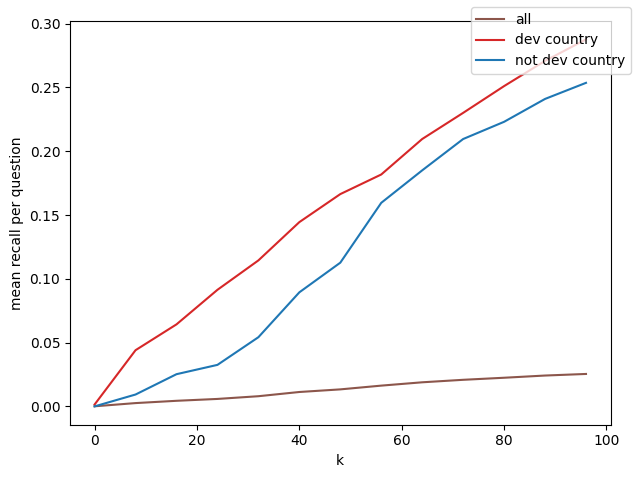

In [106]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("k")
ax1.set_ylabel("mean recall per question")
ax1.plot(top_k, mean_recall, color="tab:brown", label="all")
ax1.plot(top_k, dev_mean_recall, color=color, label="dev country")
ax1.plot(top_k, no_dev_mean_recall, color="tab:blue", label="not dev country")

fig.tight_layout()
fig.legend()

In [48]:
no_dev_dataset.groupby("q_id")[["is_answer", "q_id"]].apply(
    lambda x: x.head(65)["is_answer"].sum() / q_answers[x["q_id"].iloc[0]]
).mean()

0.012474380640753659

In [55]:
no_dev_dataset.groupby("q_id")[["is_answer", "q_id"]].apply(
    lambda x: x.head(85)["is_answer"].sum()
).mean()

0.05436697709539391

In [49]:
full_dataset.groupby("q_id")[["is_answer", "q_id"]].apply(
    lambda x: x.head(65)["is_answer"].sum() / q_answers[x["q_id"].iloc[0]]
).mean()

0.018090264044203132

In [84]:
mean_answers = []
dev_mean_answers = []
no_dev_mean_answers = []
for k in top_k:
    mean_answers.append(
        full_dataset[["is_answer", "q_id", "idx"]]
        .groupby("q_id")
        .apply(lambda x: x[x["idx"] <= k]["is_answer"].sum())
        .mean()
    )
    dev_mean_answers.append(
        dev_dataset[["is_answer", "q_id", "idx"]]
        .groupby("q_id")
        .apply(lambda x: x[x["idx"] <= k]["is_answer"].sum())
        .mean()
    )
    no_dev_mean_answers.append(
        no_dev_dataset[["is_answer", "q_id", "idx"]]
        .groupby("q_id")
        .apply(lambda x: x[x["idx"] <= k]["is_answer"].sum())
        .mean()
    )

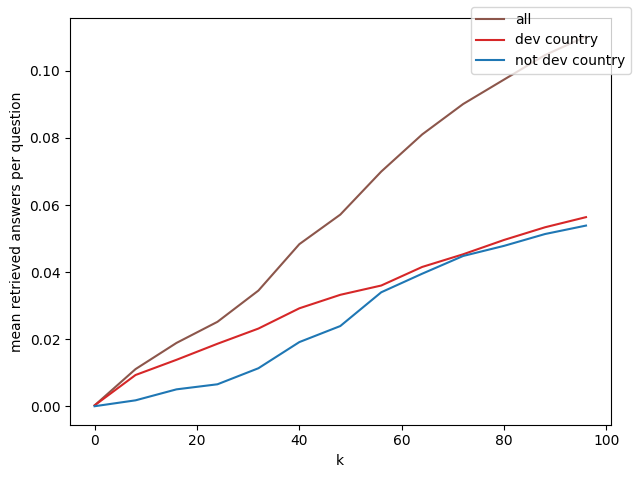

In [86]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("k")
ax1.set_ylabel("mean retrieved answers per question")
ax1.plot(top_k, mean_answers, color="tab:brown", label="all")
ax1.plot(top_k, dev_mean_answers, color=color, label="dev country")
ax1.plot(top_k, no_dev_mean_answers, color="tab:blue", label="not dev country")

fig.tight_layout()
fig.legend()

In [79]:
total_answers = []
dev_total_answers = []
no_dev_total_answers = []
for k in top_k:
    total_answers.append(
        full_dataset[["is_answer", "q_id", "idx"]]
        .groupby("q_id")
        .apply(lambda x: x[x["idx"] <= k]["is_answer"].sum())
        .sum()
    )
    dev_total_answers.append(
        dev_dataset[["is_answer", "q_id", "idx"]]
        .groupby("q_id")
        .apply(lambda x: x[x["idx"] <= k]["is_answer"].sum())
        .sum()
    )
    no_dev_total_answers.append(
        no_dev_dataset[["is_answer", "q_id", "idx"]]
        .groupby("q_id")
        .apply(lambda x: x[x["idx"] <= k]["is_answer"].sum())
        .sum()
    )

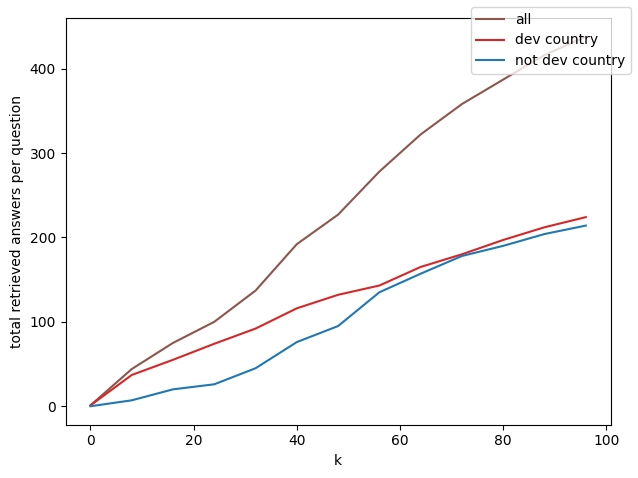

In [80]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("k")
ax1.set_ylabel("total retrieved answers per question")
ax1.plot(top_k, total_answers, color="tab:brown", label="all")
ax1.plot(top_k, dev_total_answers, color=color, label="dev country")
ax1.plot(top_k, no_dev_total_answers, color="tab:blue", label="not dev country")

fig.tight_layout()
fig.legend();